# Проект: Обучение с учителем: качество модели

**Описание проекта:**\
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

**Цель проекта:**\
Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**План работы:**
1. Загрузка и изучение данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Объединение таблиц
5. Корреляционный анализ
6. Использование пайплайнов
7. Анализ важности признаков
8. Сегментация покупателей
9. Общий вывод

In [1]:
# Установка библиотек
!pip install phik 
!pip install shap
!pip install scikit-learn==1.1.3 -q
# !pip install numpy --upgrade
# !pip install matplotlib --upgrade

     |████████████████████████████████| 686 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 539 kB 1.3 MB/s eta 0:00:01


In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import sklearn
import shap

In [3]:
# Инструменты
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder, PolynomialFeatures
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer 
from sklearn.feature_selection import SelectKBest, f_classif
from phik.report import plot_correlation_matrix
from scipy import stats as st
from matplotlib import pyplot as plt
from phik import phik_matrix
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка и изучение данных

In [5]:
market = pd.read_csv('/datasets/market_file.csv')
m_money = pd.read_csv('/datasets/market_money.csv')
time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=",")

In [6]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [7]:
market.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [8]:
market.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


In [9]:
m_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [10]:
m_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [11]:
m_money.describe()

,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


In [12]:
time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [13]:
time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [14]:
time.describe()

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


In [15]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [16]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [17]:
money.describe()

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


**Вывод по разделу 1**
- В таблицах отсутствуют пропуски - количество значений в столбцах соответствует количеству строк;
- Типы данных в каждом стоблце во всех таблицах соответсвуют действительности;
- Названия стоблцов необходимо привести к нижнему регистру и можно сократить, не теряя смысла названия столбца;
- Необходимо проверить данные на явные и неявные дубликаты

## Предобработка

In [18]:
#переименование столбцов датасета market
market = market.rename(columns={'Покупательская активность':'активность',
                                'Тип сервиса':'сервис', 
                                'Разрешить сообщать':'рассылка', 
                                'Маркет_актив_6_мес':'актив_6_мес', 
                                'Маркет_актив_тек_мес':'актив_тек_мес', 
                                'Длительность':'длительность', 
                                'Акционные_покупки':'акции', 
                                'Популярная_категория':'категория', 
                                'Средний_просмотр_категорий_за_визит':'категорий_за_визит', 
                                'Неоплаченные_продукты_штук_квартал':'неоплачено_штук', 
                                'Ошибка_сервиса':'ошибки', 
                                'Страниц_за_визит':'страницы'})

#переименование столбцов датасета m_money
m_money = m_money.rename(columns={'Период': 'период', 
                                  'Выручка': 'выручка'})

#переименование столбцов датасета time
time = time.rename(columns={'Период':'период', 
                            'минут':'минуты'})

#переименование столбцов датасета money
money = money.rename(columns={'Прибыль':'прибыль'})

#проверка изменения названий столбцов
market.columns, m_money.columns, time.columns, money.columns

(Index(['id', 'активность', 'сервис', 'рассылка', 'актив_6_мес',
        'актив_тек_мес', 'длительность', 'акции', 'категория',
        'категорий_за_визит', 'неоплачено_штук', 'ошибки', 'страницы'],
       dtype='object'),
 Index(['id', 'период', 'выручка'], dtype='object'),
 Index(['id', 'период', 'минуты'], dtype='object'),
 Index(['id', 'прибыль'], dtype='object'))

In [19]:
market.duplicated().sum() #проверка на явные дубликаты

0

In [20]:
m_money.duplicated().sum() #проверка на явные дубликаты

0

In [21]:
time.duplicated().sum() #проверка на явные дубликаты

0

In [22]:
money.duplicated().sum() #проверка на явные дубликаты

0

**Вывод по разделу 2**\
Явных дубликатов не обнаружено.

В данном разделе были выполнены:

- Поиск явных дубликатов
- Изменение названия столбцов

## Исследовательский анализ данных

### Количественные признаки

In [23]:
#создание функции для построения гистограммы диаграммы размаха для столбцов с количественными признаками
def hist_box(data, column):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.xlabel(f'Значения столбца "{column}"')
    plt.ylabel('Частота')
    plt.title(f'Гистограмма для "{column}"')
    sns.histplot(data[column], color='MediumPurple')
    plt.subplot(1, 2, 2)
    plt.xlabel(f'Значения столбца {column}')
    plt.title(f'Диаграмма размаха для {column}')
    sns.boxplot(x=data[column], color='MediumPurple')

#### market

In [24]:
#создание списка количественных столбцов датасета market
num_col_market = ['актив_6_мес', 
                  'актив_тек_мес', 
                  'длительность', 
                  'акции',
                  'категорий_за_визит',
                  'неоплачено_штук', 
                  'ошибки', 
                  'страницы']

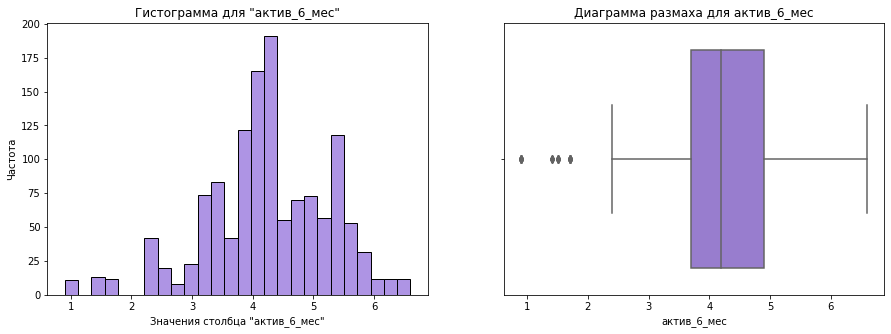

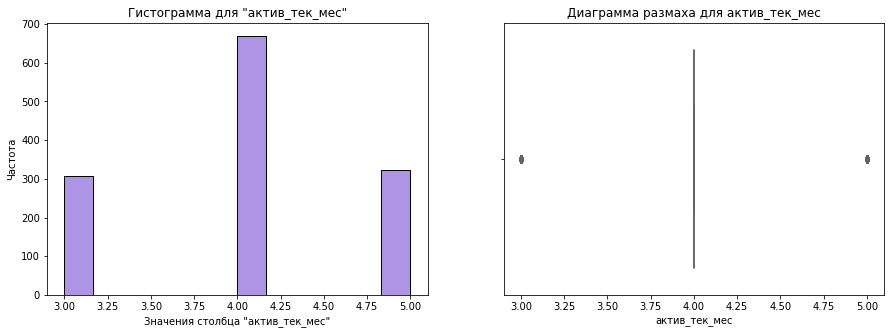

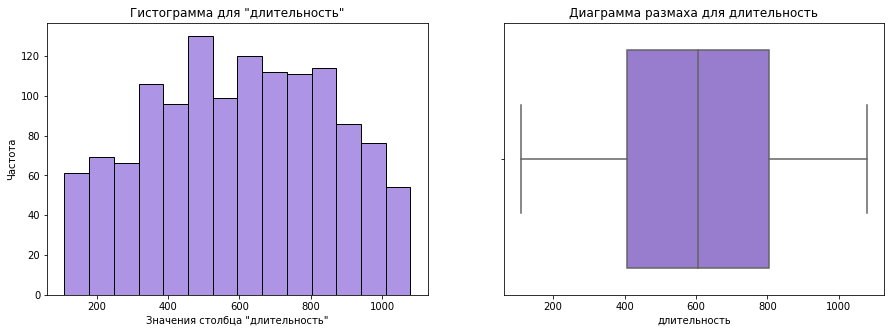

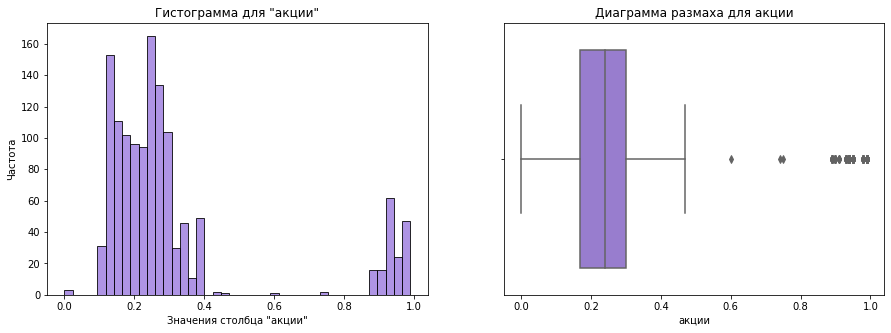

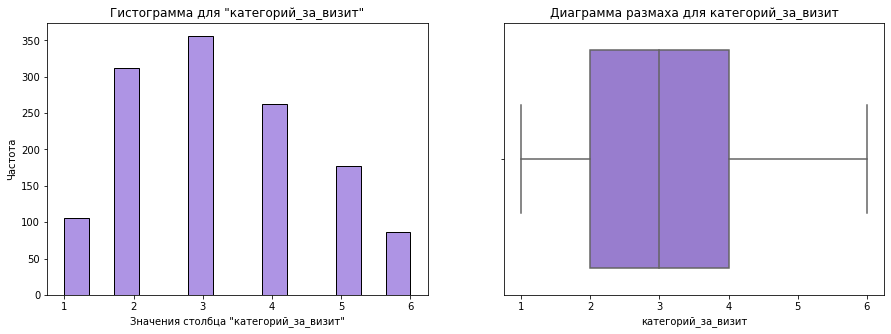

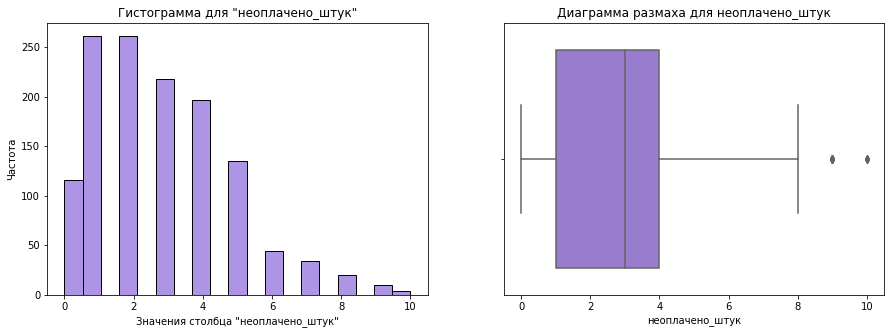

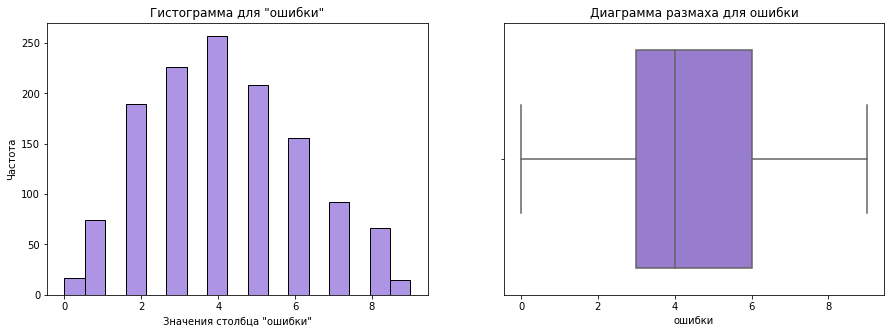

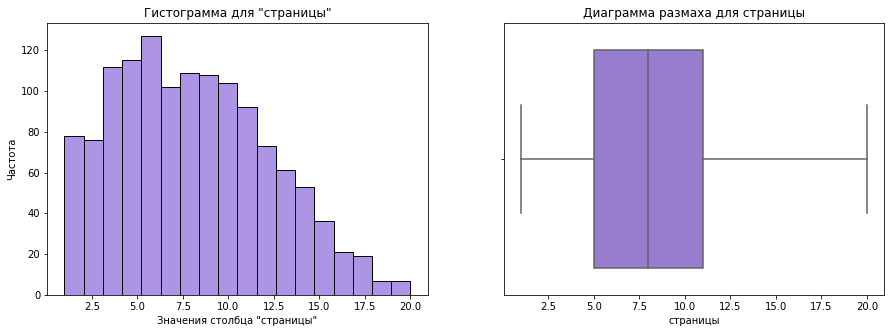

In [25]:
for name in num_col_market:
    hist_box(market, name)

- признак актив_6_мес в целом распределен нормально, есть несколько слишком малых значений. Надо иметь это ввиду, возможно придется их удалить;
- признак актив_тек_мес можно сделать категориальным признаком с 3-мя категориями;
- признак длительность в целом распределен равномерно на всём диапазоне значений;
- признак акции имеет бимодальное распределение - в области 0,2 и в области близкой к 1. Есть немалая доля покупателей, кто покупает только по акции! К ним нужно присмотреться повнимательней;
- признак категорий_за_визит имеет нормальное распределение, можно сделать категориальным признаком с 6 категориями;
- признак неоплачено_штук имеет слегка скорешенное влево распределение - редко кто хранит в корзине больше 8 предметов - будет категориальным признаком с 11 категориями;
- признак ошибки распределен нормально - будет категориальным признаком с 10 категориями;
- признак страницы имеет слегка скошенное влево нормальное распределение.

#### m_money

In [26]:
#создание списка количественных столбцов датасета m_money
num_col_m_money = ['выручка'] 

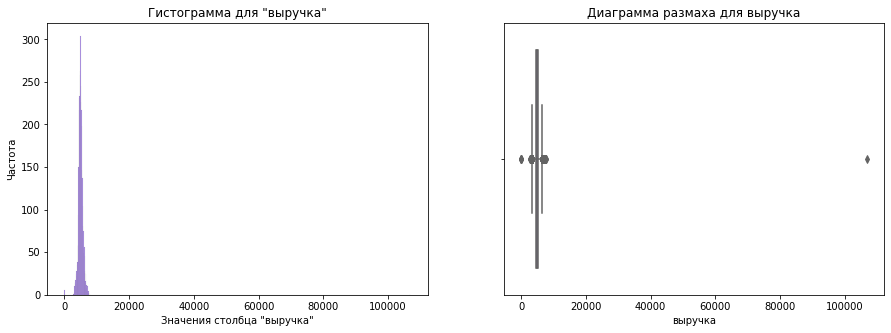

In [27]:
#построение распределений количественных признаков датасета m_money
for name in num_col_m_money:
    hist_box(m_money, name)

In [28]:
#нахождение выбросов
m_money.query('выручка > 20000')

,id,период,выручка
98,215380,текущий_месяц,106862.2


In [29]:
#удаление аномально большого значения выручки
m_money = m_money.query('выручка < 20000')

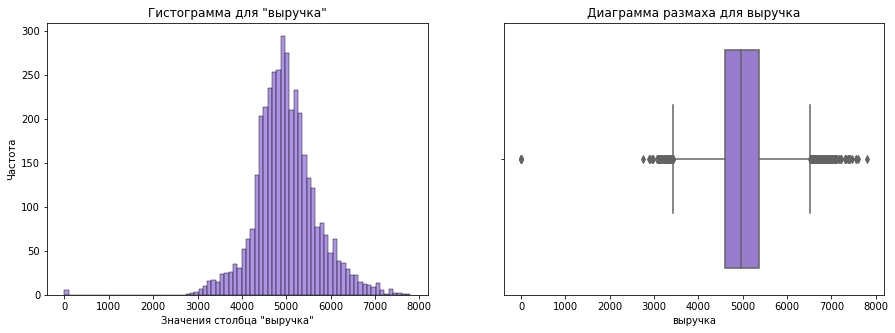

In [30]:
#удаление аномально большого значения выручки
m_money = m_money.query('выручка < 20000')
#построение распределений количественных признаков датасета m_money без выбросов
for name in num_col_m_money:
    hist_box(m_money, name)

Признак минуты распределен нормально.

#### time

In [31]:
#создание списка количественных столбцов датасета m_money
num_col_time = ['минуты'] 

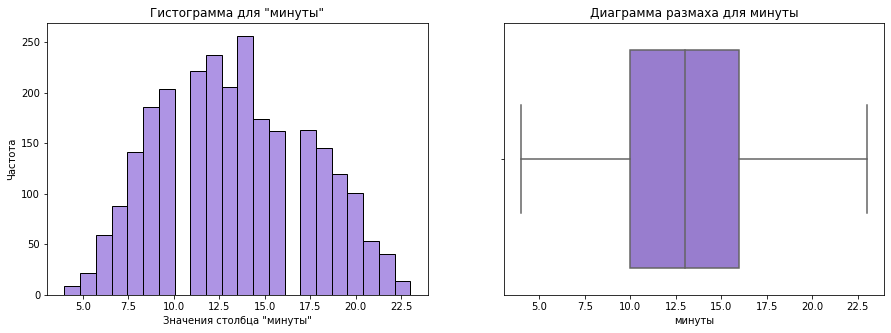

In [32]:
#построение распределений количественных признаков датасета time
for name in num_col_time:
    hist_box(time, name)

Признак минуты распределен нормально.

#### money

In [33]:
#создание списка количественных столбцов датасета m_money
num_col_money = ['прибыль'] 

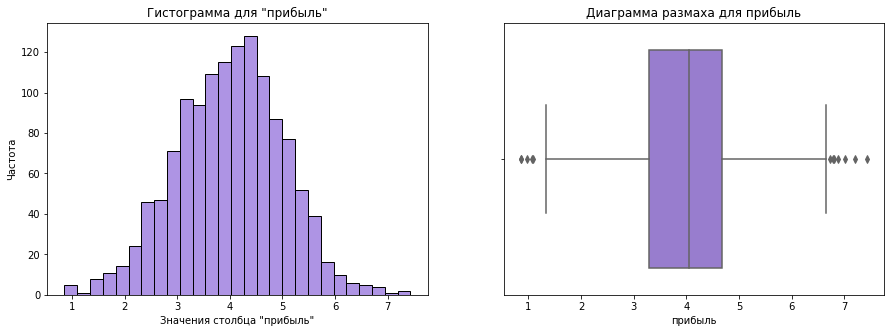

In [34]:
for name in num_col_money:
    hist_box(money, name)

Признак прибыль распределен нормально.

### Категориальные признаки

In [35]:
#создание функции для построения круговой диаграммы размаха для столбцов с категориальными признаками
def pie_gr(data, spisok, name):
    for elem in spisok:
        plt.title(elem, fontsize='xx-large')
        fig = plt.gcf()
        fig.set_size_inches(5,5)
        plt.pie(data.groupby(data[elem])[name].count(),
           labels=data.groupby(data[elem])[name].count().index,
           startangle=90,
           radius=1.2,
           autopct='%1.1f%%',
           wedgeprops={'linewidth': 3, 'edgecolor':'white'},
           colors=sns.color_palette('pastel'));
        plt.show()

#### market

In [36]:
#создание списка категориальных столбцов датасета market
cat_col_market = ['активность', 'сервис', 'рассылка', 'категория']

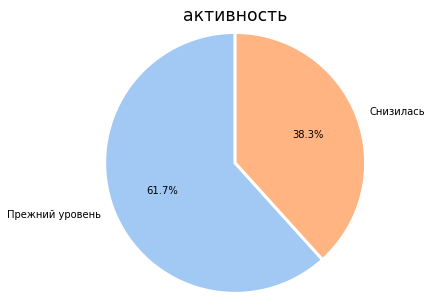

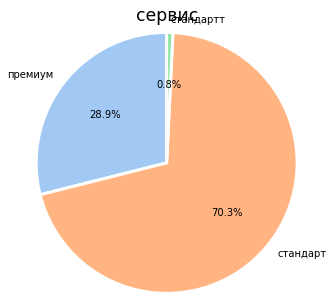

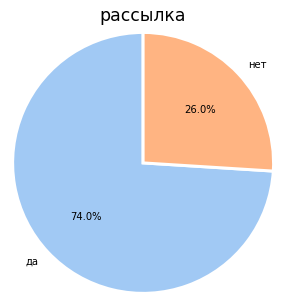

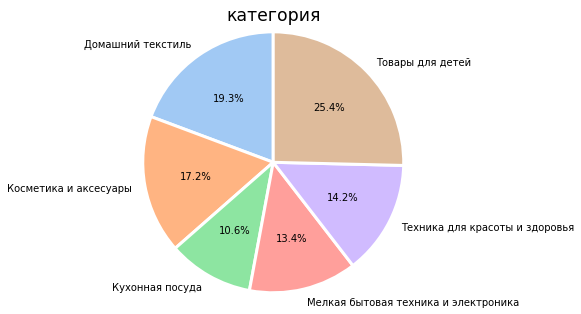

In [37]:
pie_gr(market, cat_col_market, 'id')

- у признака сервис есть странная категория "стандартт", которую нужно переделать в "стандарт";
- других необычных значений в признаках не наблюдается;
- также стоит отметить несбалансированность признаков.

In [38]:
#замена значения в признаке "сервис"
market['сервис'] = market['сервис'].replace('стандартт', 'стандарт')

#### m_money

In [39]:
#создание списка категориальных признаков датасета m_money
cat_col_m_money = ['период']

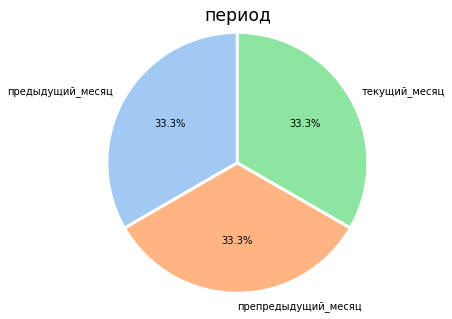

In [40]:
#круговые диаграммы для датасета m_money
pie_gr(m_money, cat_col_m_money, 'id')

Признак распределен равномерно, странных значений категории нет.

#### time

In [41]:
#создание списка категориальных признаков датасета time
cat_col_time = ['период']

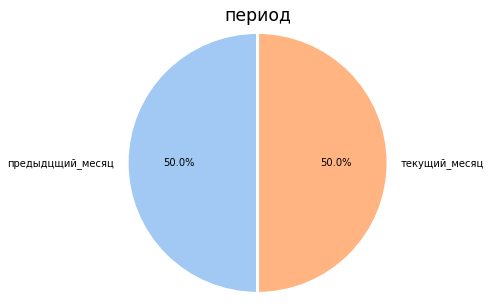

In [42]:
#круговые диаграммы для датасета time
pie_gr(time, cat_col_time, 'id')

In [43]:
#замена значения в признаке "период"
time['период'] = time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

Признак распределен равномерно. Изменено значение "предыдцщий_месяц" на "предыдущий_месяц" для последующего объединения таблиц по этому столбцу.

In [44]:
# Отберем клиентов с покупательской активностью не менее трёх месяцев в market
agg_dict = {'период': ['count']}
grouped = m_money.query('выручка > 0').groupby('id').agg(agg_dict)
grouped.columns = ['count']

grouped = grouped[grouped['count'] == 3]
market = market[market['id'].isin(grouped.index)]
len(market)

1296

4 пользователя из 1300 без активности в течение трех последних месяцев отсеялись.

## Объединение таблиц

In [45]:
# Создадим сводную таблицу с данными о выручке за каждый месяц из m_money
m_money_grouped = m_money.pivot_table(index=['id'], columns=["период"])
m_money_grouped.columns = ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']
m_money_grouped['id'] = m_money_grouped.index
m_money_grouped.head(3)

,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,id
id,,,,
215348,0.0,0.0,3293.1,215348
215349,5216.0,4472.0,4971.6,215349
215350,5457.5,4826.0,5058.4,215350


In [46]:
# Создадим сводную таблицу с данными о минутах за каждый месяц из time
time_grouped = time.pivot_table(index=['id'], columns=["период"])
time_grouped.columns = ['минут_предыдущий_месяц', 'минут_текущий_месяц']
time_grouped['id'] = time_grouped.index
time_grouped.head(3)

,минут_предыдущий_месяц,минут_текущий_месяц,id
id,,,
215348,13,14,215348
215349,12,10,215349
215350,8,13,215350


4 пользователя без активности в течение каждого из трех последних месяце отсеялись.

In [47]:
# Объединим данные из market и сводных таблиц m__grouped и time_grouped
market_full = market.join(m_money_grouped, on='id', lsuffix="_left", rsuffix="_выручка")
market_full = market_full.rename(columns={'id_left':'id'})
market_full = market_full.join(time_grouped, on='id', lsuffix="_left", rsuffix="_минут")
market_full = market_full.rename(columns={'id_left':'id'})
market_full = market_full.drop(['id_выручка', 'id_минут'], axis=1)
market_full.head(3)

,id,активность,сервис,рассылка,актив_6_мес,актив_тек_мес,длительность,акции,категория,категорий_за_визит,неоплачено_штук,ошибки,страницы,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13


Данные объединены, выручка и кол-во минут разбиты по месяцам. Данные из money не понадобятся в модеровании, поэтому не включены в итоговый датафрейм.

## Корреляционный анализ

interval columns not set, guessing: ['id', 'актив_6_мес', 'актив_тек_мес', 'длительность', 'акции', 'категорий_за_визит', 'неоплачено_штук', 'ошибки', 'страницы', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц']


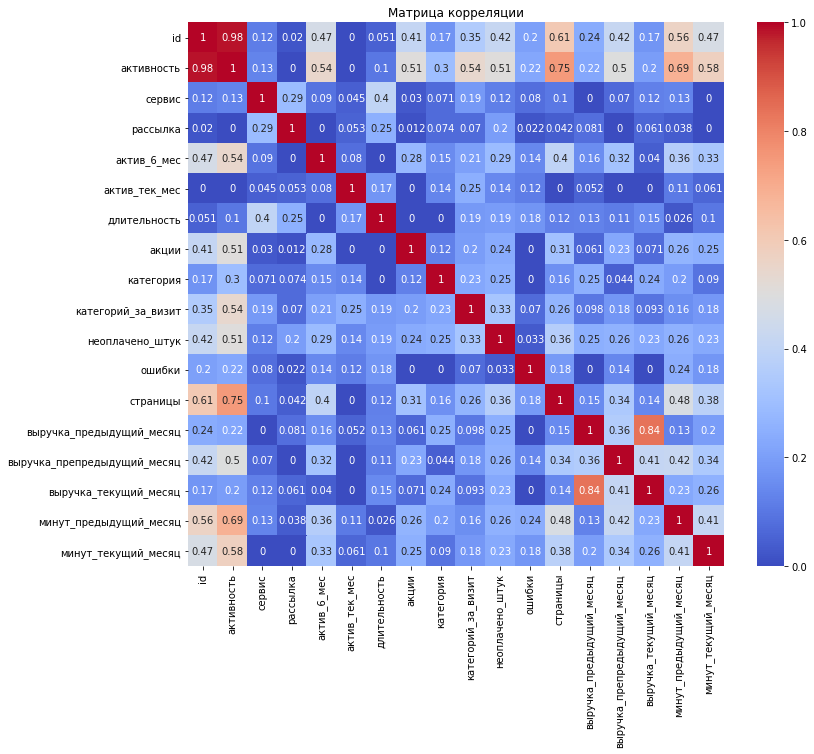

In [48]:
corr_matrix = market_full.phik_matrix()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show();

Целевым признаком является Покупательская_активность и вот список полей, которые имеют хоть корреляцию с ним: Маркет_актив_6_мес, Акционные_покупки, Средний_просмотр_категорий_за_визит, Неоплаченные_продукты_штук_квартал, Страниц_за_визит, Выручка_препредыдущий_месяц, минут_предыдущий_месяц, минут_текущий_месяц.
Среди признаков замечана только одна более менее сильная корреляция Выручка_предыдущий_месяц, Выручка_текущий_месяц. Но значение корреляции меньше 0.9 поэтому не будем удалять признаки.
Так же график показывает странную корреляцию Покупательская_активность и id, так что id так же уберем из датасета и так как он нам еще понадобиться то превратим его в индекс датасета.

## Использование пайплайнов

In [49]:
# Сделаем id индексом
market_full = market_full.set_index('id')

In [50]:
# Закодируем целевой признак активность в значение 0 и 1 
market_full['активность'] = market_full['активность']\
.apply( lambda x: 1 if x=='Снизилась' else 0 )
market_full['активность'] = market_full['активность'].astype(int)

In [51]:
X = market_full.drop('активность', axis=1)
y = market_full['активность']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = y
)

In [52]:
X_train.head(3)

,сервис,рассылка,актив_6_мес,актив_тек_мес,длительность,акции,категория,категорий_за_визит,неоплачено_штук,ошибки,страницы,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
id,,,,,,,,,,,,,,,,
215858,стандарт,да,5.5,4,510,0.15,Мелкая бытовая техника и электроника,2,4,7,16,5170.5,4347.0,6014.2,20,6
215361,стандарт,да,5.1,4,199,0.23,Техника для красоты и здоровья,4,5,2,3,6400.0,4597.0,3789.7,11,13
215884,стандарт,да,4.3,5,997,0.17,Мелкая бытовая техника и электроника,5,1,3,11,4113.0,4626.0,3798.4,13,10


In [53]:
ohe_columns = ['рассылка', 'категория', 'сервис']
num_columns = ['актив_6_мес', 'актив_тек_мес', 'длительность', 
               'категорий_за_визит', 'неоплачено_штук',
               'ошибки', 'страницы', 'выручка_предыдущий_месяц', 
               'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 
               'минут_предыдущий_месяц', 'минут_текущий_месяц','акции']

In [54]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='error', sparse=False))
    ]
)

In [55]:
ord_pipe = Pipeline(
    [
        (
            'simple_imputer_ord_before',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'simple_imputer_ord_after',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [56]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [57]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [58]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(3, 8),
        'models__max_features': range(3,8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [59]:
param_grid

[{'models': [DecisionTreeClassifier(random_state=42)],
  'models__max_depth': range(3, 8),
  'models__max_features': range(3, 8),
  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
 {'models': [KNeighborsClassifier()],
  'models__n_neighbors': range(2, 6),
  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
 {'models': [LogisticRegression(penalty='l1', random_state=42, solver='liblinear')],
  'models__C': range(1, 5),
  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}]

In [60]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [61]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(sparse=False))]),
                                                                               ['рассылка',
                                                                                'категория',
                                                                                'сервис']),
                                                                              ('num',
                                                                               MinMaxScaler(),
                                                                               ['актив_6_мес',
                                                                                'актив_тек_мес',
                                                                                'длительность',
                                                                                'к...
                                                               'passthrough']},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(2, 6),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(C=4,
                                                                       penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [62]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', round(randomized_search.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['рассылка', 'категория',
                                                   'сервис']),
                                                 ('num', MinMaxScaler(),
                                                  ['актив_6_мес',
                                                   'актив_тек_мес',
                                                   'длительность',
                                   

In [63]:
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_params_) 


Лучшая модель и её параметры:

 {'preprocessor__num': MinMaxScaler(), 'models__C': 4, 'models': LogisticRegression(C=4, penalty='l1', random_state=42, solver='liblinear')}


In [64]:
# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
y_test_pred = randomized_search.predict(X_test)
y_test_proba = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_test_proba[:,1]), 2)}')

Метрика ROC-AUC на тестовой выборке: 0.92


In [65]:
print(f'Метрика F1-score на тестовой выборке: {round(f1_score(y_test, y_test_pred, average="macro"), 2)}')

Метрика F1-score на тестовой выборке: 0.9


На данном шаге исследования была найдена и обучена модель для определения снижения активности покупателей сервиса. Лучшие результаты показала модель LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear').

ROC-AUC: ROC-AUC (площадь под ROC-кривой) измеряет качество модели на всех уровнях вероятностей, что делает ее хорошо приспособленной для оценки моделей на дисбалансированных данных, как в нашем примере.

Метрика roc_auc для тестовой выборки показала результат 0.9, для тестовой выборки 0.92. Показатели очень хорошие, наша модель хорошо справляется с предсказанием. Так же метрика f1 показала 0.9.
Дисбаланс в классах не помешал получить такие высокие метрики.


## Шаг 7. Анализ важности признаков

In [66]:
X_train.head()

,сервис,рассылка,актив_6_мес,актив_тек_мес,длительность,акции,категория,категорий_за_визит,неоплачено_штук,ошибки,страницы,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
id,,,,,,,,,,,,,,,,
215858,стандарт,да,5.5,4,510,0.15,Мелкая бытовая техника и электроника,2,4,7,16,5170.5,4347.0,6014.2,20,6
215361,стандарт,да,5.1,4,199,0.23,Техника для красоты и здоровья,4,5,2,3,6400.0,4597.0,3789.7,11,13
215884,стандарт,да,4.3,5,997,0.17,Мелкая бытовая техника и электроника,5,1,3,11,4113.0,4626.0,3798.4,13,10
216564,стандарт,да,5.6,4,342,0.94,Кухонная посуда,2,7,5,8,4930.0,5269.0,4766.2,14,19
215715,премиум,да,3.6,5,873,0.39,Товары для детей,3,2,2,5,3716.0,4691.0,4600.0,10,10


7.1 Оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP. 
7.2 Сделайте выводы о значимости признаков:
какие признаки мало значимы для модели;
какие признаки сильнее всего влияют на целевой признак;
как можно использовать эти наблюдения при моделировании и принятии бизнес-решений.

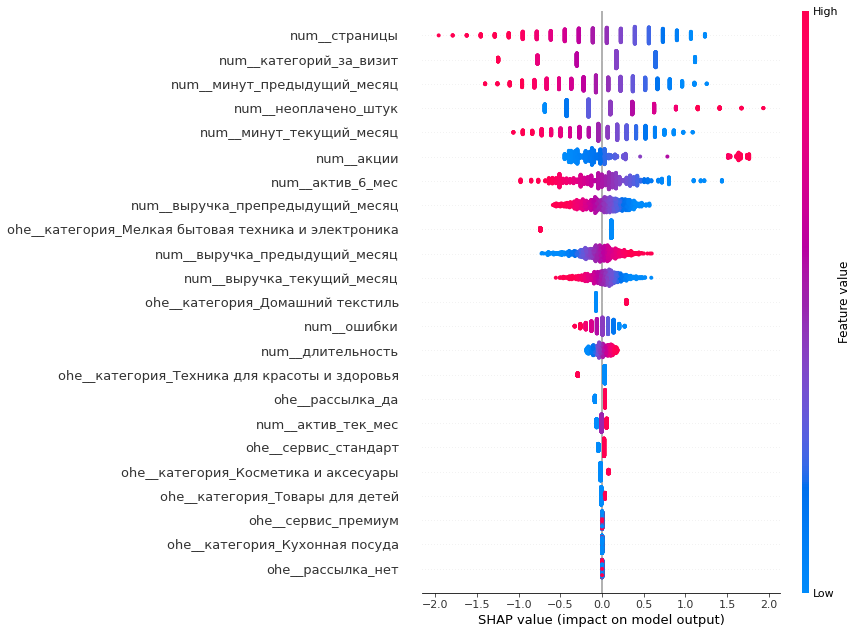

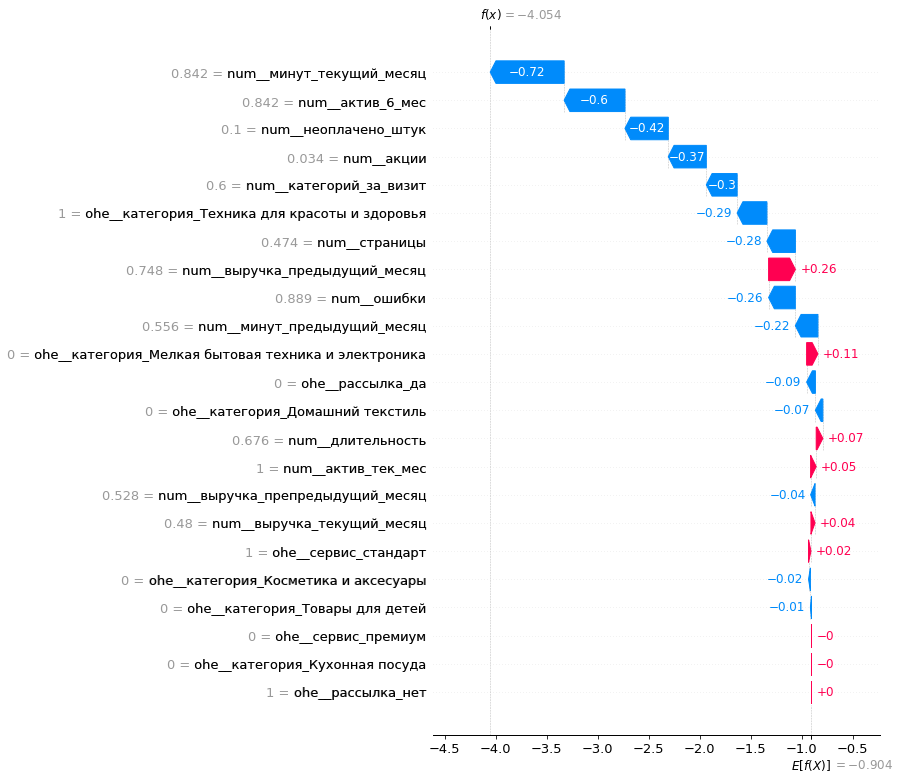

In [67]:
X_train_shap = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
explainer = shap.LinearExplainer(
    randomized_search.best_estimator_.named_steps['models'],
    X_train_shap
)

feature_names = randomized_search.best_estimator_[:-1].get_feature_names_out()
X_train_shap = pd.DataFrame(data=X_train_shap, columns=feature_names)

shap_values = explainer(X_train_shap)

shap.plots.beeswarm(shap_values, max_display=23)
shap.plots.waterfall(shap_values[5], max_display=23) 
#display(shap.plots.bar(shap_values, max_display=23))

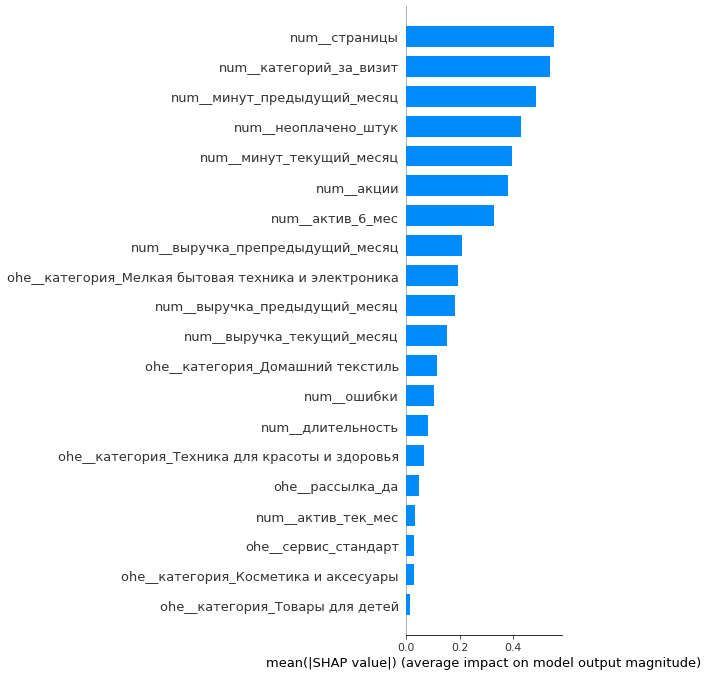

In [68]:
# Код reviewer
 
X_test_shap = pipe_final.named_steps['preprocessor'].fit_transform(X_test) 
shap.summary_plot(shap_values, X_test_shap, plot_type = 'bar')

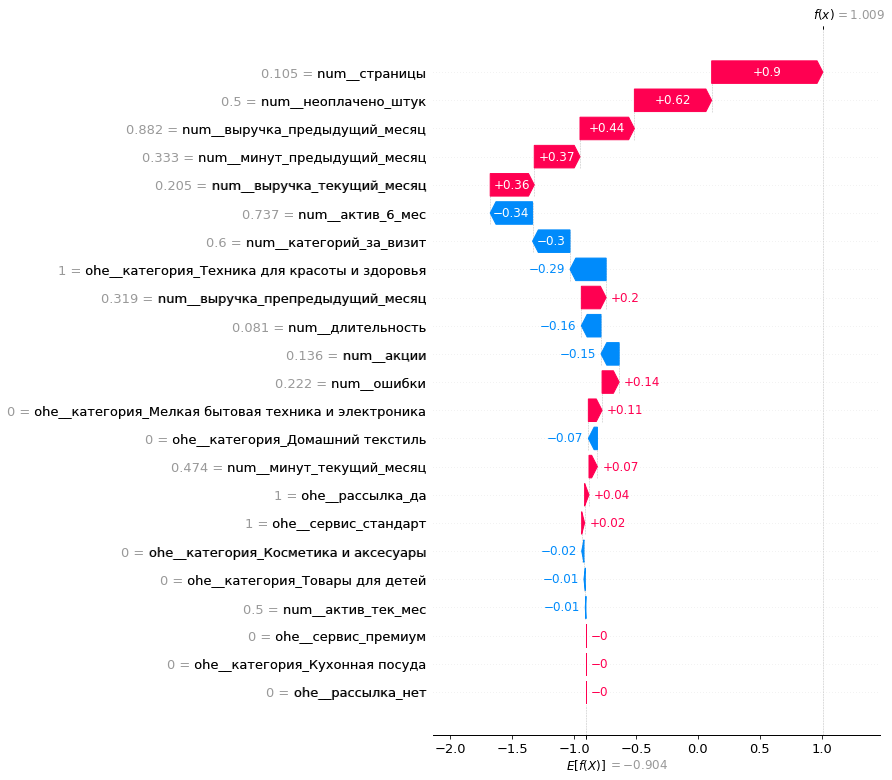

In [69]:
shap.plots.waterfall(shap_values[1], max_display=23)

Наиболее важные признаки, которые помогли присвоить модели итоговое значение целевого (общий вклад):
- Категория товара Мелкая бытовая техника и электроника,
- Категории за визит,
- Количество минут,
- Акции.

Наименьший вклад:
- Длительность,
- Сервис премиум,
- Активность в текущем месяце,
- Категоря кухонная посуда,
- категория косметика и аксессуары.


## Шаг 8. Сегментация покупателей

In [70]:
X_test['вероятность'] = y_test_proba[:, 1]
data = X_test.sort_values(by='вероятность')
data.head()

,сервис,рассылка,актив_6_мес,актив_тек_мес,длительность,акции,категория,категорий_за_визит,неоплачено_штук,ошибки,страницы,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,вероятность
id,,,,,,,,,,,,,,,,,
215775,стандарт,нет,5.0,4,157,0.15,Мелкая бытовая техника и электроника,5,0,5,13,4028.0,4934.0,3372.8,19,16,0.002613
216624,стандарт,да,5.4,5,806,0.17,Домашний текстиль,6,1,8,11,5565.5,5096.0,6102.4,22,19,0.004079
216410,премиум,да,4.8,3,939,0.11,Домашний текстиль,6,1,7,12,4273.0,4465.0,4236.6,21,23,0.004167
216589,стандарт,да,4.1,5,447,0.14,Косметика и аксесуары,6,0,9,12,5430.5,5045.0,5894.6,20,17,0.004645
216553,стандарт,да,6.1,4,298,0.27,Домашний текстиль,6,3,6,16,5028.5,5039.0,5149.4,19,14,0.007421


In [71]:
num_columns

['актив_6_мес',
 'актив_тек_мес',
 'длительность',
 'категорий_за_визит',
 'неоплачено_штук',
 'ошибки',
 'страницы',
 'выручка_предыдущий_месяц',
 'выручка_препредыдущий_месяц',
 'выручка_текущий_месяц',
 'минут_предыдущий_месяц',
 'минут_текущий_месяц',
 'акции']

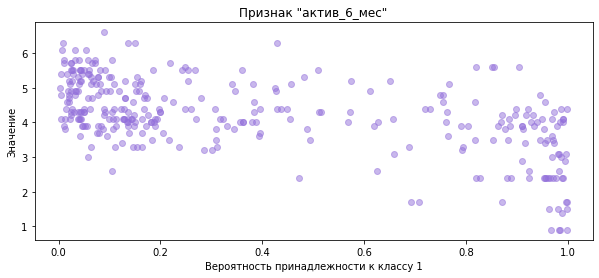

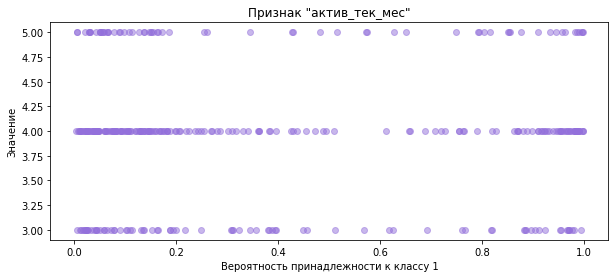

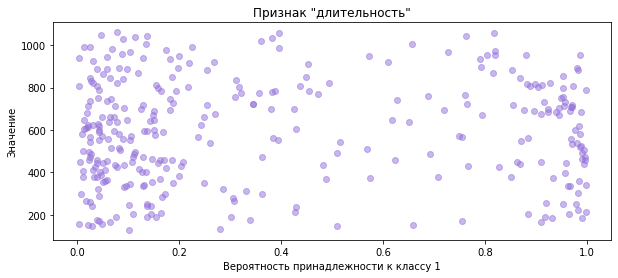

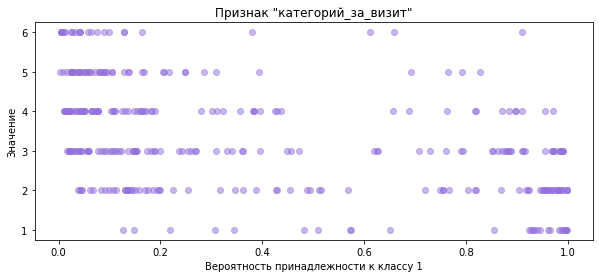

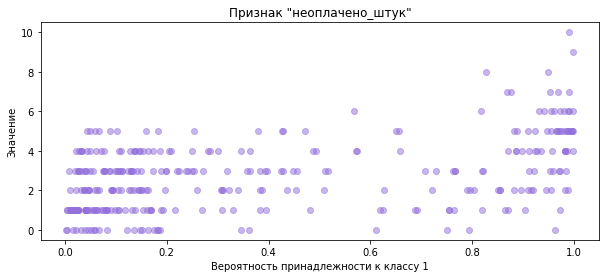

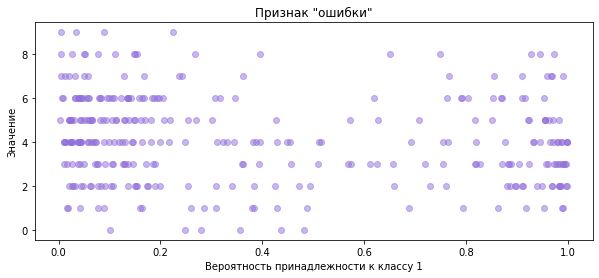

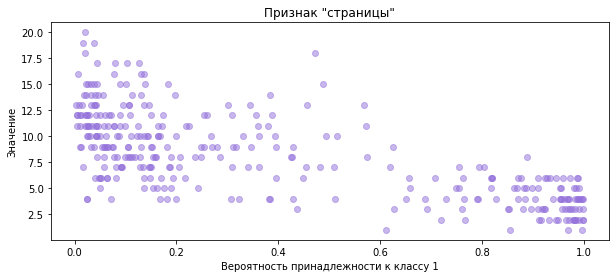

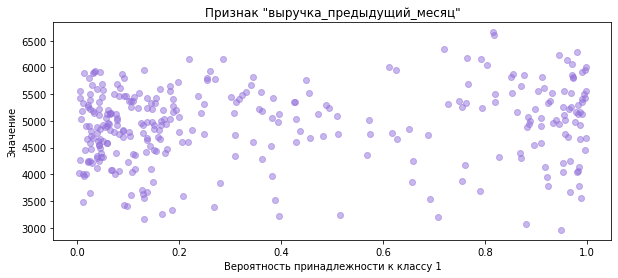

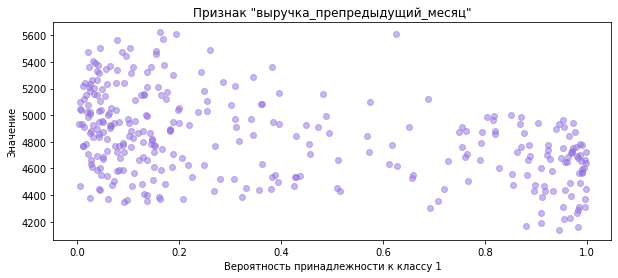

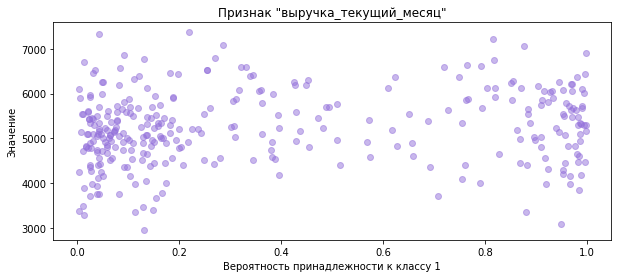

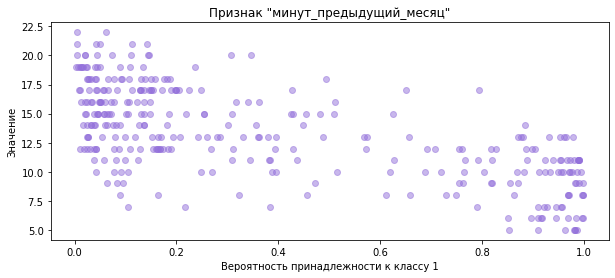

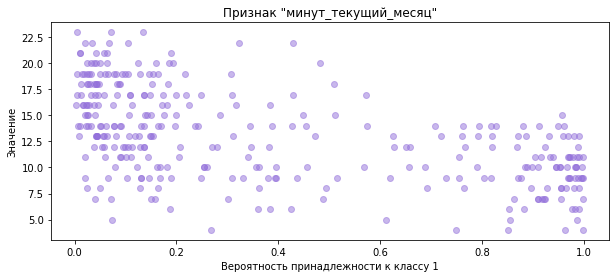

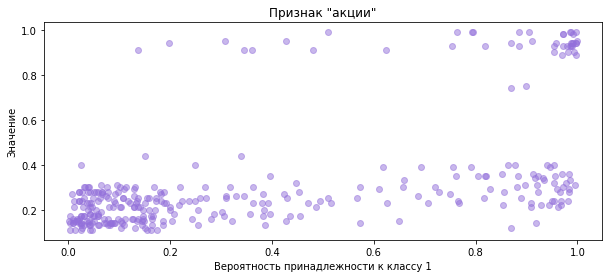

In [72]:
#построение scatter plot для распределения числовых 
#признаков в зависимости от вероятности принадлежности к классу

for name in num_columns:
    plt.figure(figsize=(10, 4))
    plt.title(f'Признак "{name}"')
    plt.xlabel('Вероятность принадлежности к классу 1')
    plt.ylabel(f'Значение')
    plt.scatter(x=data['вероятность'], 
                y=data[name],
                alpha=0.5, 
                c='MediumPurple')

На основании приведенных графиков можно выделить следующие пороги значений признака для разделения покупателей на классы. В частности, покупатели со сниженной активностью имеют значения признака:

- актив_6_мес менее 4;
- акции выше 0.6;
- категорий_за_визит не более 3;
- неоплачено_штук более 4;
- страницы менее 7;
- выручка_препредыдущий месяц ниже 5000;
- минут_предыдудущий_месяц ниже 12,5;
- минут_текущий_месяц ниже 14.
В остальных признаках сложно выделить пороги.

Можно выделить сегмент покупателей, которые редко скроллят ленту сайта, то есть со значениями признака "страницы" менее 7, поскольку активность таких покупателей снизилась в последнее время.

In [73]:
df = market_full.query('страницы < 7')
df.shape

(505, 17)

In [74]:
def hist_box_graph_1(dataset, column):
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.title(f'Гистограмма для "{column}"')
    sns.histplot(data=dataset, x=column, hue='активность', palette='BuPu')
    plt.xlabel(f'Значение параметра "{column}"')
    plt.ylabel('Частота')
    
    plt.subplot(1, 2, 2)
    plt.title(f'Диаграмма размаха для "{column}"')
    sns.boxplot(x='активность', y=column, data=dataset, palette='BuPu');
    plt.ylabel(f'Значение параметра "{column}"')

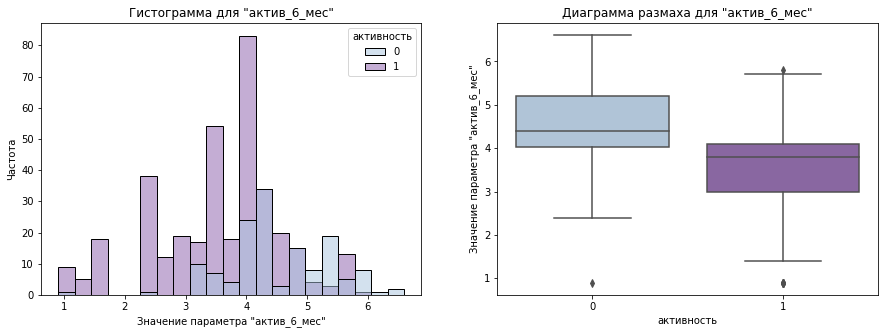

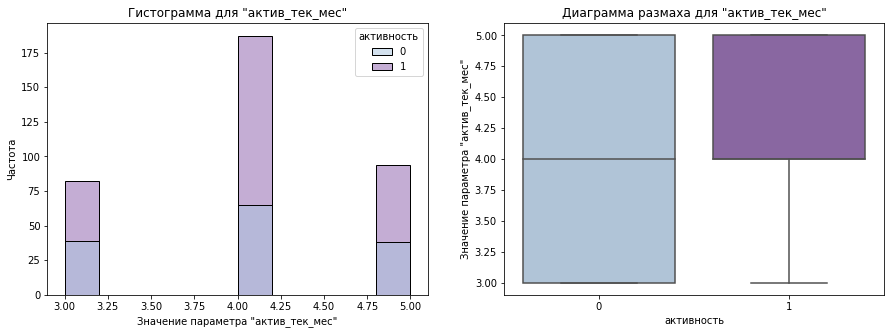

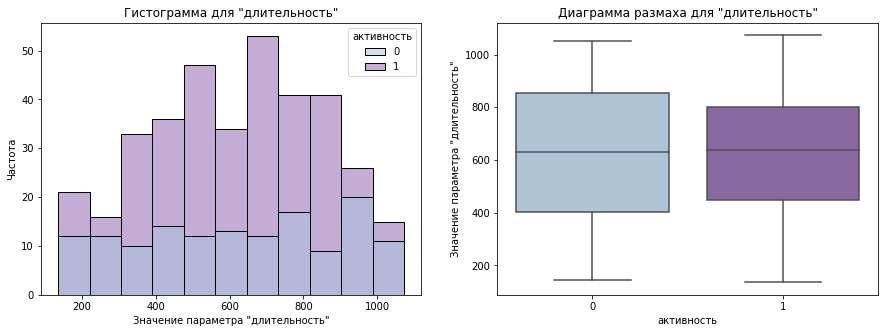

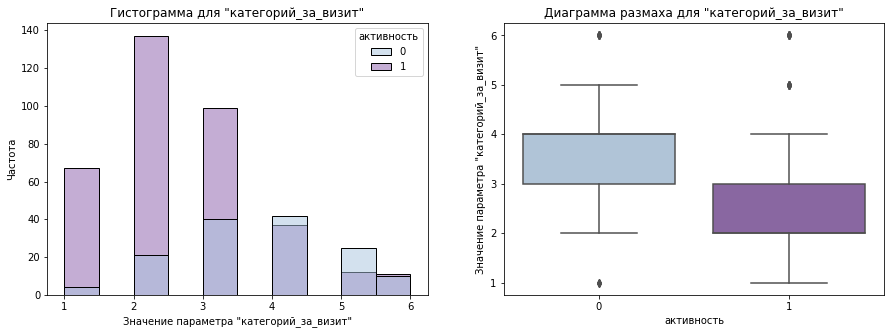

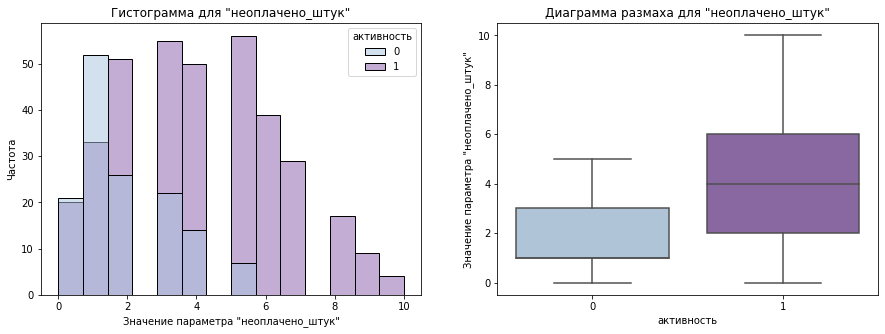

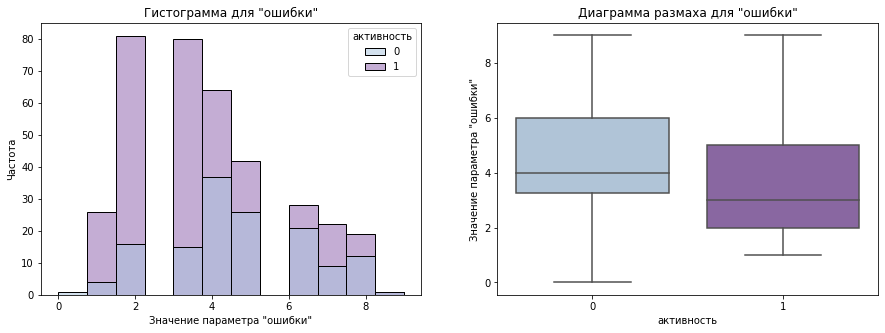

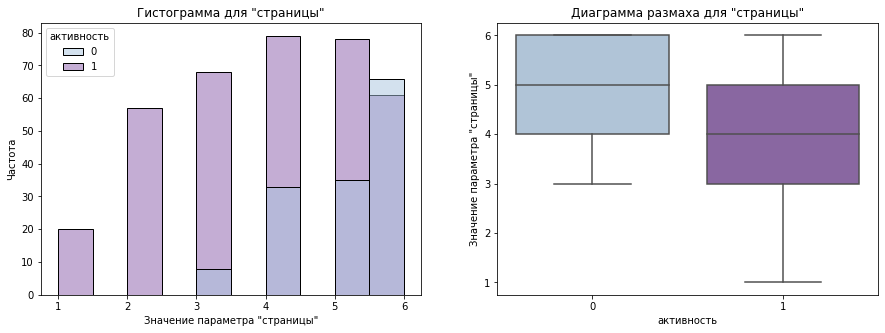

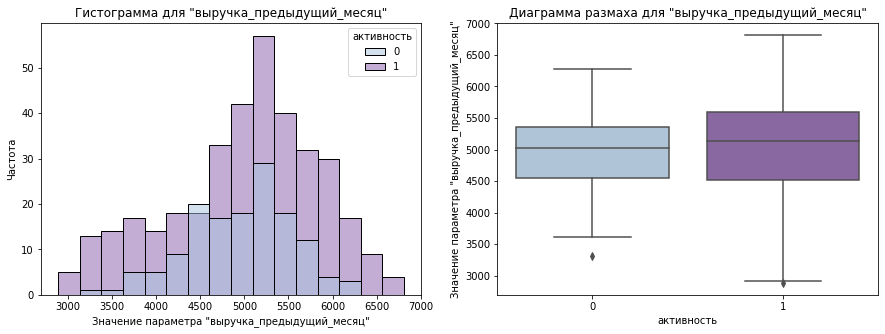

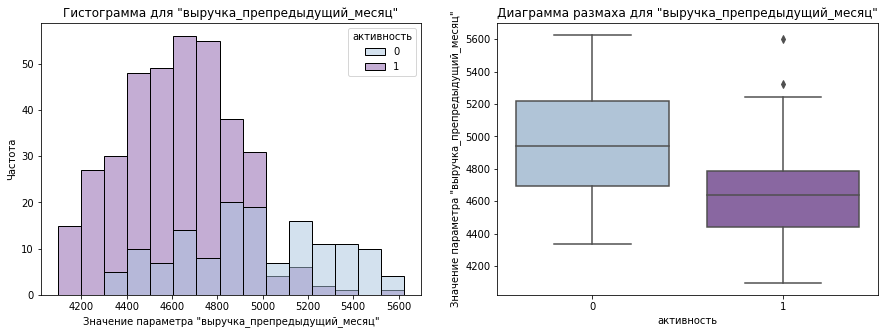

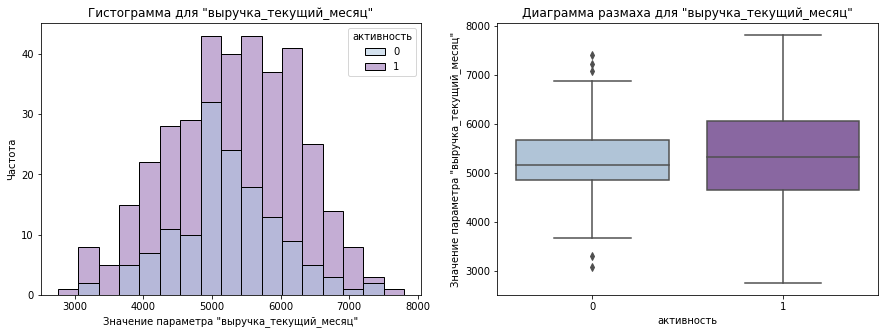

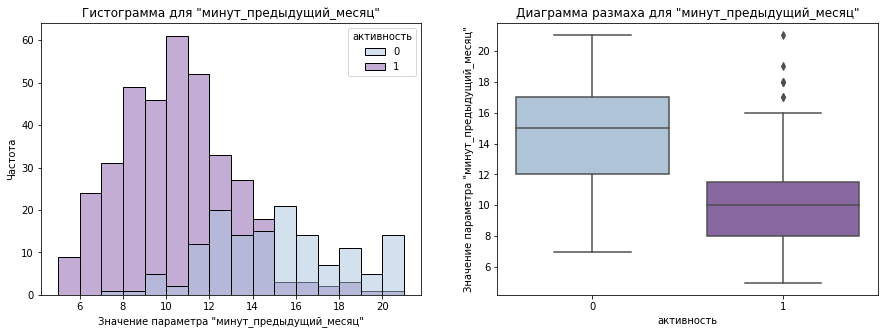

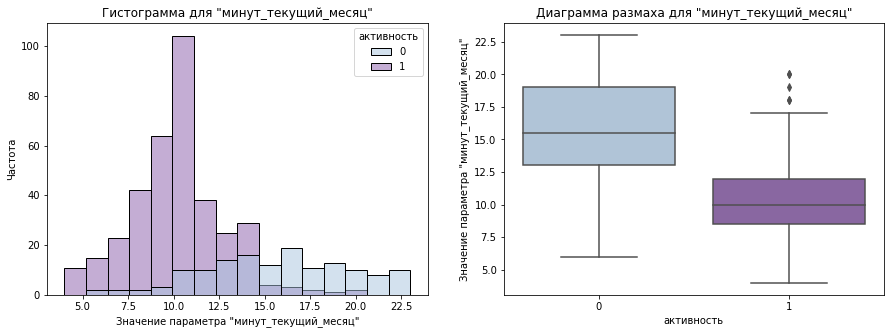

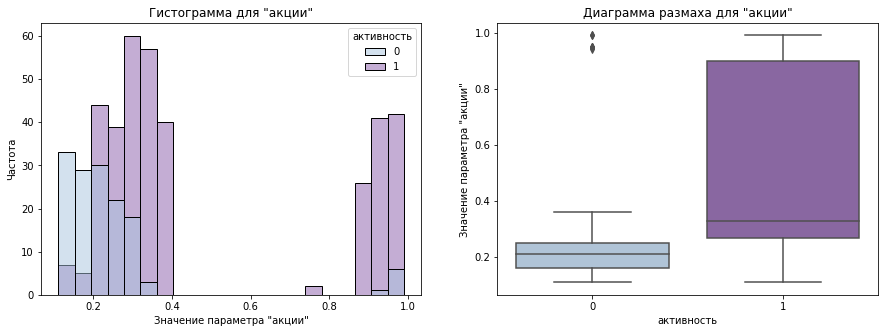

In [75]:
for name in num_columns:
    hist_box_graph_1(df, name)

In [76]:
cat_col_ = ['сервис', 'рассылка', 'категория']

In [77]:
df_2 = df.reset_index()

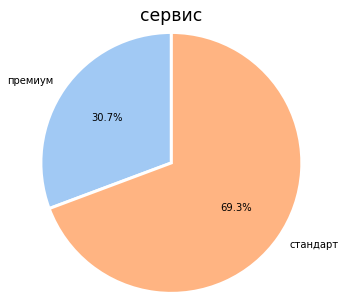

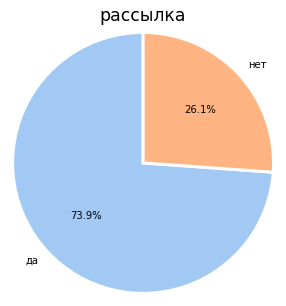

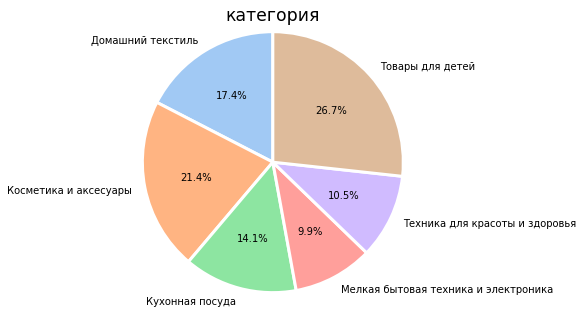

In [78]:
pie_gr(df_2, cat_col_, 'id')

Данный сегмент покупателей в основном покупает товары для детей и домашний текстиль. Также большинство таких покупателей не покупает по акциям, хотя им приходят рассылка различных предложений.

Возможно данной категории пользователей стоит разослать акции на товары для детей.

In [79]:
money_2 = money.set_index('id')

In [80]:
df = pd.merge(df, money_2, left_index = True, right_index = True, how = 'inner')
df.head()

,активность,сервис,рассылка,актив_6_мес,актив_тек_мес,длительность,акции,категория,категорий_за_визит,неоплачено_штук,ошибки,страницы,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,прибыль
id,,,,,,,,,,,,,,,,,,
215349,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,4.16
215350,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,3.13
215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,4.87
215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,4.21
215353,1,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,3.95


In [81]:
def hist_box_graph_1(dataset, column):
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.title(f'Гистограмма для "{column}"')
    sns.histplot(data=dataset, x=column, hue='активность', palette='BuPu')
    plt.xlabel(f'Значение параметра "{column}"')
    plt.ylabel('Частота')
    
    plt.subplot(1, 2, 2)
    plt.title(f'Диаграмма размаха для "{column}"')
    sns.boxplot(x='активность', y=column, data=dataset, palette='BuPu');
    plt.ylabel(f'Значение параметра "{column}"')

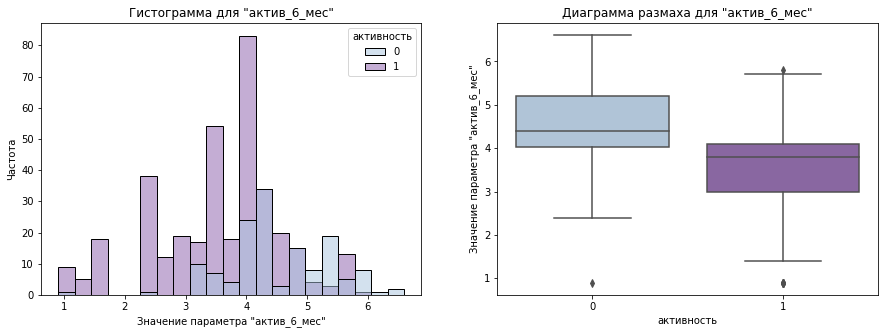

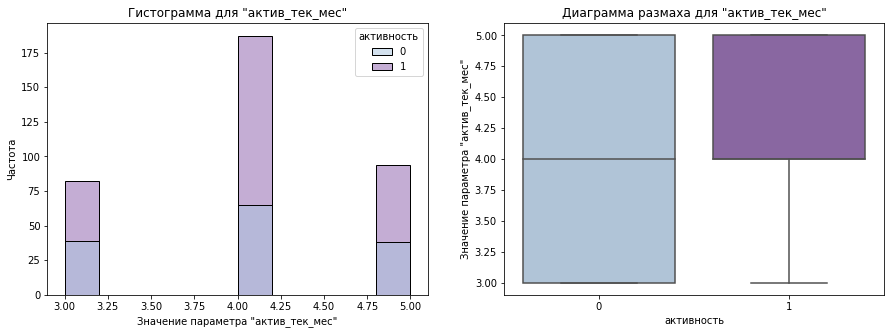

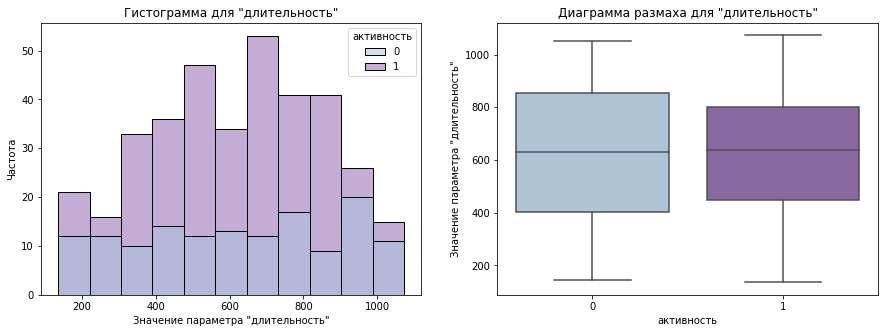

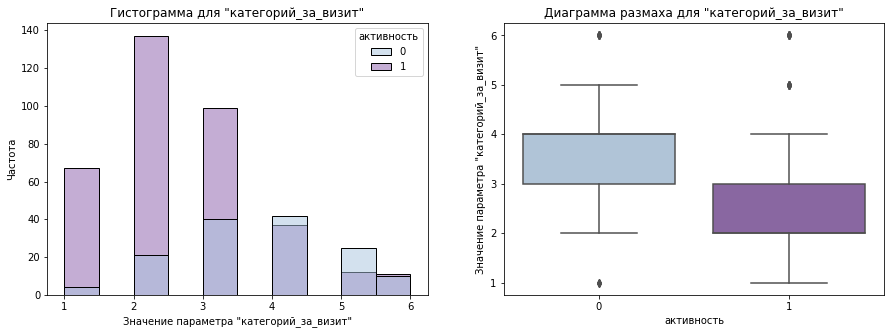

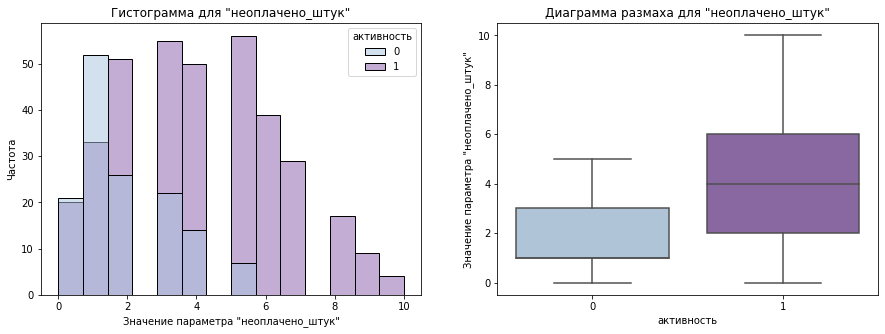

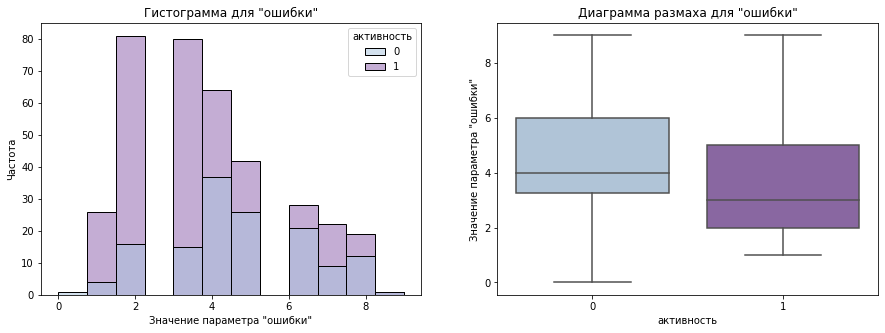

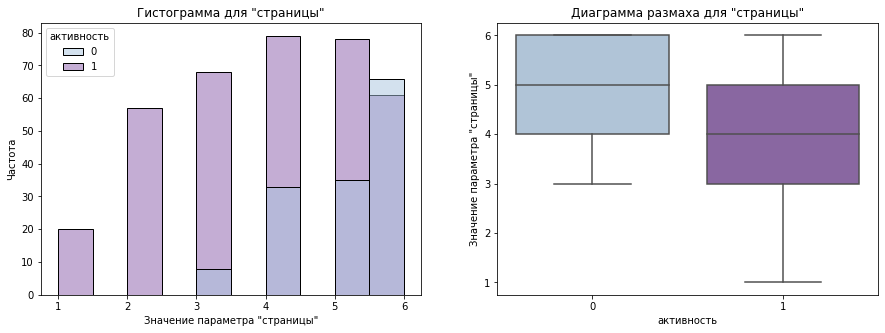

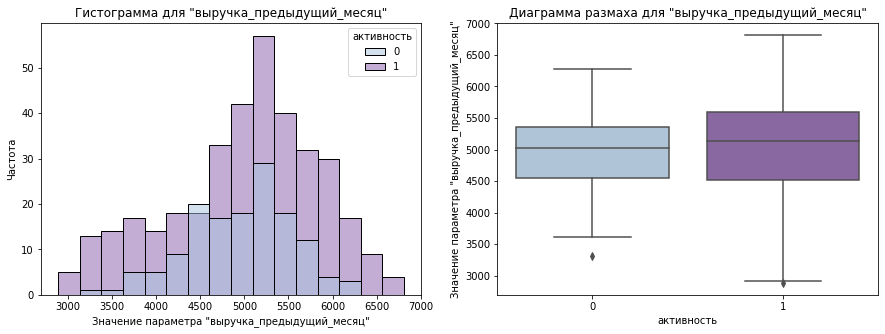

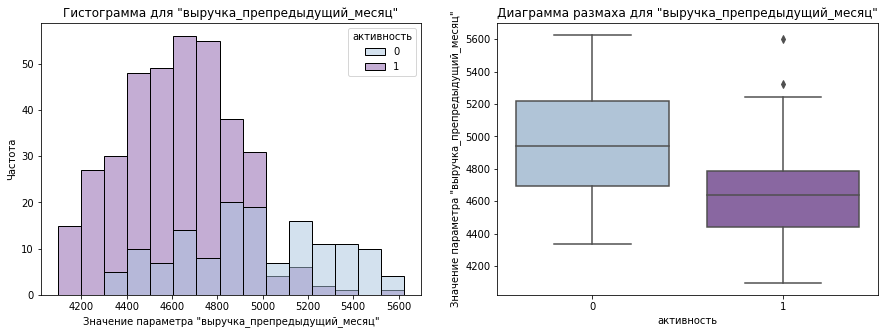

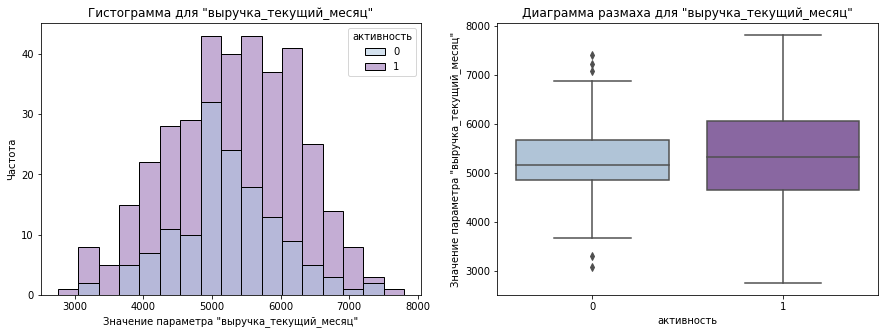

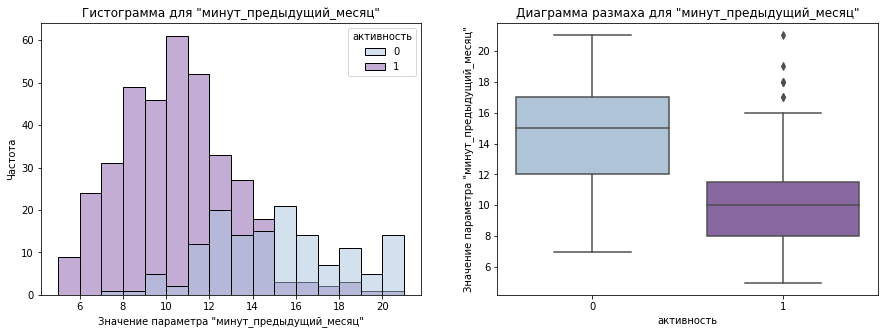

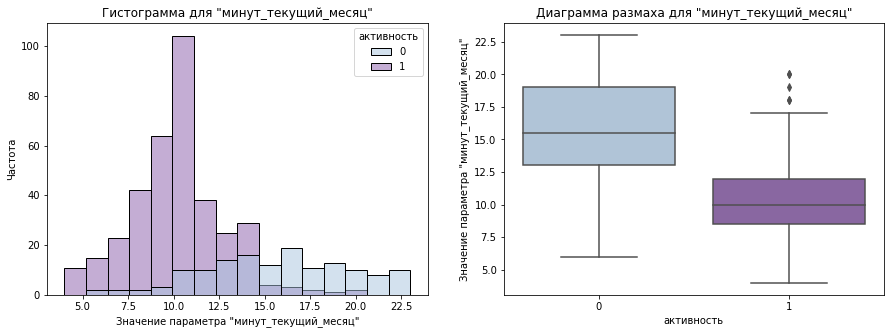

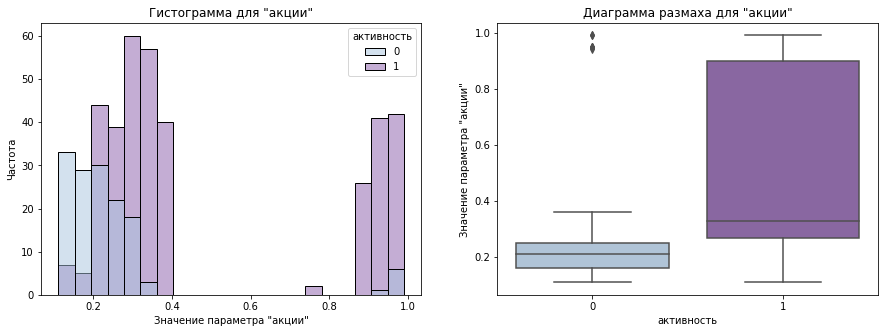

In [82]:
for name in num_columns:
    hist_box_graph_1(df, name)

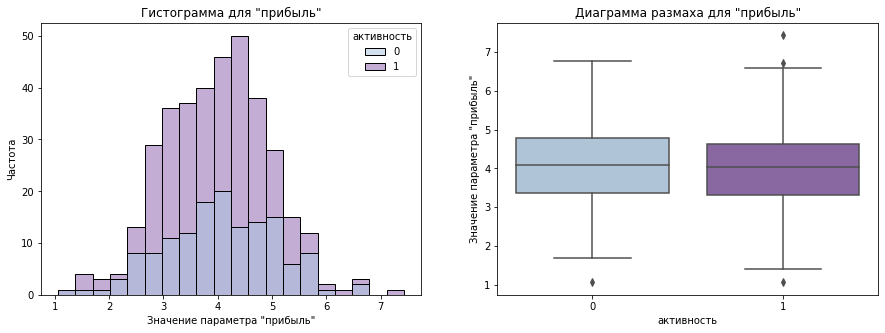

In [83]:
hist_box_graph_1(df, 'прибыль')

По прибыли практически никакой разницы нет между теми у кого снизилась активность и у кого нет.

## Шаг 9. Общий вывод

В данном проекте были проанализированы данные о покупателях интернет-магазина "В один клик" с целью прогнозирования покупательской активности в следующие 3 месяца. 

**Предварительно данные были подготовлены:**
* поиск и замена пропусков;
* поиск явных дубликатов;
* изменение названия столбцов.

Были проведены коррелляционный и исследовательский анализ.

Был проведен поиск лучшей модели МО. Ею стала модель LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear') со значением метрики roc_auc=0.92 на тестовой выборке. 

У выбранной модели была проанализирована важность признаков. Наиболее важными стали длительность (с момента регистрации), минуты, категорий за визит, страницы, выручка, ошибки, неоплачено, актив_6_мес.  